# Detecting Cyberbullying Tweets with Bidirectional LSTM and BERT Transformer

In [ ]:
!pip install matplotlib==3.4
# Update matplotlib when running on colab for ax.bar plots otherwise Plot tweets based on their counts will raise error

     |████████████████████████████████| 10.3 MB 4.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
%pip install emoji
%pip install transformers
%pip install nltk
%pip install gensim

## Import libraries


In [ ]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import emoji
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

#BERT Transformers library 
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

import time
from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random
seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

#set plot style
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Custom function - Covariance Matric

In [ ]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

## Loading the data<br>
FINE-GRAINED BALANCED CYBERBULLYING DATASET<br>
Has 46017 unique values<br>
Multiclass labels: Based on victim’s age, ethnicity, gender, religion, or other quality.<br>
Ref: J. Wang, K. Fu, C.T. Lu, “SOSNet: A Graph Convolutional Network Approach to Fine-Grained Cyberbullying Detection,” Proceedings of the 2020 IEEE International Conference on Big Data (IEEE BigData 2020), December 10-13, 2020.<br>
Link: https://ieee-dataport.org/open-access/fine-grained-balanced-cyberbullying-dataset



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/cyberbullying_tweets.csv")
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})
df.head(5)

,text,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47692 non-null  object
 1   sentiment  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


## Check for duplicate tweets

In [ ]:
df.duplicated().sum()

36

In [ ]:
#remove duplicates
df = df[~df.duplicated()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


## Check for Class Balance

In [ ]:
df.sentiment.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

## Tweet Text Cleaning and Tokenization:
Remove emojis, punctuations, links, stopwords, contractions, hashtags at the end of the sentence, special charateristics(&, $) and  multiple sequential spaces by defining custom functions

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis 
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

# #Lemmatization 
# def lemmatize(text):
#     tokenized = nltk.word_tokenize(text)
#     lm = WordNetLemmatizer()
#     return ' '.join([lm.lemmatize(words) for words in tokenized])

#Apply all the defined functions in the following order:
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  """


In [ ]:
df['text_clean'] = texts_new
df.head(5)

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...


### Check for duplicate tweets after the tweet cleaning


In [ ]:
df["text_clean"].duplicated().sum()

3058

In [ ]:
df.drop_duplicates("text_clean", inplace=True)
df.shape

(44598, 3)

### Check for class balance after tweet cleaning

In [ ]:
df.sentiment.value_counts()

religion               7946
age                    7884
ethnicity              7744
not_cyberbullying      7637
gender                 7607
other_cyberbullying    5780
Name: sentiment, dtype: int64

Decision of removing generic class - "other_cyberbullying"
Since a lot of tweets of the class "other_cyberbullying" have been removed, it becomes a very unbalanced class when compared to the other classe. Also class "other_cyberbullying" consists of "generic" tweets, so it was removed for further analysis


In [ ]:
df = df[df["sentiment"]!="other_cyberbullying"]
df_network = df
df_network.sentiment.value_counts()


religion             7946
age                  7884
ethnicity            7744
not_cyberbullying    7637
gender               7607
Name: sentiment, dtype: int64

### Get class names in a list

In [ ]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

## Tweets length analysis

In [ ]:
# A new dataframe column was created which contains the length of the cleaned tweets in terms of number of words.
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
df['text_len'] = text_len

### Plot tweets based on their counts 



and remove tweets that are too short (less than 4 words) and that are too long (more than 100 words) 
No of samples after removing too short & too long tweets = 37113 rows 

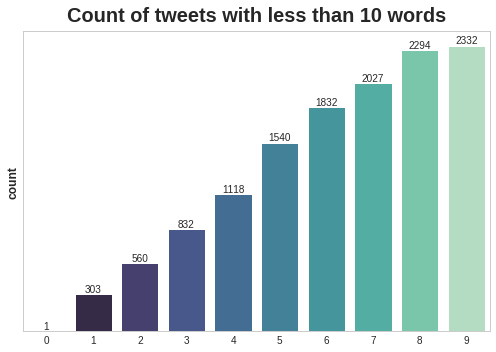

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
# remove tweets that are too short (less than 4 words)
df = df[df['text_len'] > 3]

In [ ]:
# check for long tweets
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,ethnicity,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
10274,@holliebakerlutz What does that 23% figure rep...,gender,23 figur repres deriv,4
5229,are bully sticks for dogs safe,not_cyberbullying,bulli stick dog safe,4
10314,RT @Mr_LayedBak: I'm not sexist... but women r...,gender,rt sexist women ref,4
5237,*hands you a bag of trail mix*,not_cyberbullying,hand bag trail mix,4


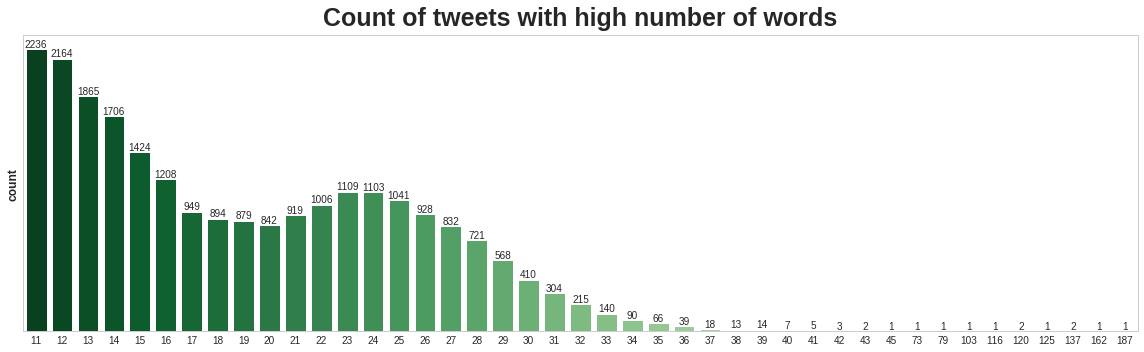

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Greens_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
# remove tweets that are too long (with more than 100 words)
df = df[df['text_len'] < 100]
#get the length of the longest tweet
max_len = np.max(df['text_len'])
max_len 

79

In [ ]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerda como nosotra tambin eramo victima del...,79
44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,73
45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45
21241,And yet God was able to meet their needs using...,religion,yet god abl meet need use radic everyday gener...,43
41749,@seijohgorl hoy mami keito AAAA okay so um ika...,ethnicity,hoy mami keito aaaa okay um ikaw talaga one fi...,43
...,...,...,...,...
44750,What the fuck you dumb nigger I hate you now,ethnicity,fuck dumb nigger hate,4
1673,@UMTony lmao! I really wanted to take it down!,not_cyberbullying,lmao realli want take,4
35335,He's a grade school bully. He's a coward!,age,grade school bulli coward,4
3920,Need to let my anger out dude.,not_cyberbullying,need let anger dude,4


## Sentiment column encoding

In [ ]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##Train - Val -Test split

In [ ]:
X = df['text_clean']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

#### Oversampling the training set to balance the classes

In [ ]:
# Oversampling the training set so that all classes have the same count as the most populated one
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment'])

In [ ]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

# Naive Bayes baseline model:As a simple baseline model

### Create a bag of words using CountVectorizer

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)


TF-IFD transformation is performed to transform a count matrix to tf-idf representation. tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval as it associates weigths to the different words based on their frequency such that rarer words will be given more importance

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

### Instantiate the Naive Bayes mode

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.85      0.97      0.91      1579
         age       0.80      0.98      0.88      1566
   ethnicity       0.90      0.92      0.91      1542
      gender       0.89      0.85      0.87      1462
not bullying       0.84      0.47      0.60      1274

    accuracy                           0.85      7423
   macro avg       0.86      0.84      0.84      7423
weighted avg       0.86      0.85      0.84      7423



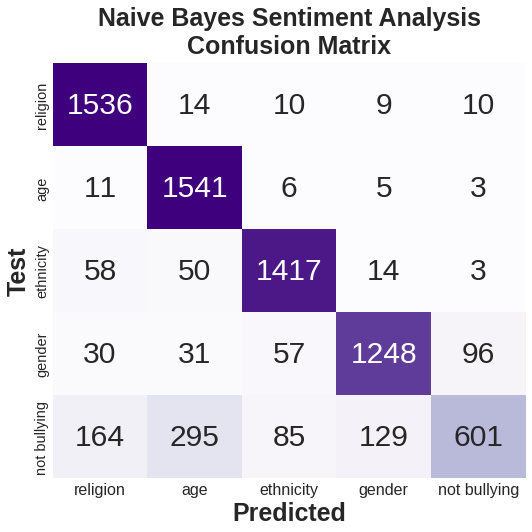

In [ ]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

Overall accuracy for Naive Bayes was 85%. The Precision, Recall and F1 score  for all cyberbylling classes have very high F1 scores, whereas for the class "non-cyberbullying" the score is much lower. 

# Custom Bidirectional LSTM 

Data preprocessing for LSTM:
Includes tokenizing the sentences with a custom defined function. 
The sentences will be converted to lists of number with padding to the max number of words in a sentence.

In [ ]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [ ]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [ ]:
#print an example tweet that has been tokenized:
df["text_clean"].iloc[195]

'cours would also fight theocraci regardless religion'

In [ ]:
# sentence is transformed to the vector
tokenized_column[195]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,  634,   27,   71,  161, 5561,
       1469,  124])

TOP 20 most common words: Extract top 20 words from the vocabulary dictionary 
we created with the tokenizer.

In [ ]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


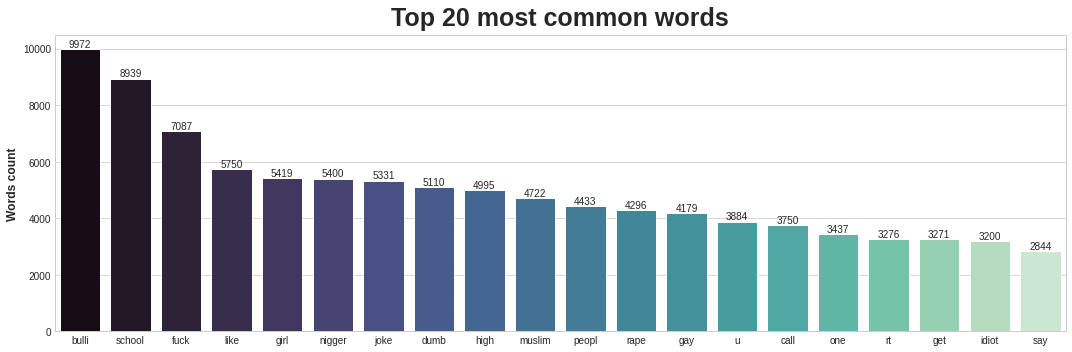

In [ ]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

Word Embedding by Word2Vec: Create a word embedding matrix using the original text tweets and the pre trained model Word2vec.
1. Create a list of words from the X_train vector


In [ ]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
#set a dimension of the embedding words(the number of featurs of each transformed word)
EMBEDDING_DIM = 200

In [ ]:
#instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object
word2vec_model = Word2Vec(Word2vec_train_data, size=200)

#### Before defining the embedding matrix, choose the max number of words and to do it extract the number of words from the vocabulary python dictionary 


In [ ]:
print(f"Vocabulary size: {len(vocabulary) + 1}")
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Vocabulary size: 33009


In [ ]:
#define embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (33009, 200)


#### Train - Validation - Test dataset split from the tokenized sentences

In [ ]:
X = tokenized_column
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [ ]:
#check balance of the target classes
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

In [ ]:
#Random oversamplinging on the training set to overcome class imbalance
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

#### PyTorch datasets and dataloaders

In [ ]:
# Transform to tensor datasets and dataloaders for the LSTM training, validation and testing.
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=32, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=32, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=32, drop_last=True)

#### PyTorch LSTM modeling


In [ ]:
NUM_CLASSES = 5 # Multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
BATCH_SIZE = 32
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(33009, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Loss function: Negative log likelihood loss <br>
Optimizer: Adam

In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

#### LSTM Training loop 

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.153533).  Saving model ...
	Train_loss : 0.6667 Val_loss : 0.2316
	Train_acc : 74.517% Val_acc : 92.154%
Epoch 2:Validation accuracy increased (92.153533 --> 93.240489).  Saving model ...
	Train_loss : 0.1797 Val_loss : 0.1998
	Train_acc : 94.134% Val_acc : 93.240%
Epoch 3:Validation accuracy increased (93.240489 --> 93.410326).  Saving model ...
	Train_loss : 0.1153 Val_loss : 0.1988
	Train_acc : 96.216% Val_acc : 93.410%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0750 Val_loss : 0.2256
	Train_acc : 97.601% Val_acc : 92.595%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0517 Val_loss : 0.3084
	Train_acc : 98.478% Val_acc : 89.538%


In [ ]:
# Load the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

#### LSTM Testing

In [ ]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [ ]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.95      0.95      0.95      1572
         age       0.96      0.98      0.97      1559
   ethnicity       0.98      0.98      0.98      1537
      gender       0.94      0.88      0.91      1455
not bullying       0.82      0.86      0.84      1269

    accuracy                           0.93      7392
   macro avg       0.93      0.93      0.93      7392
weighted avg       0.94      0.93      0.94      7392



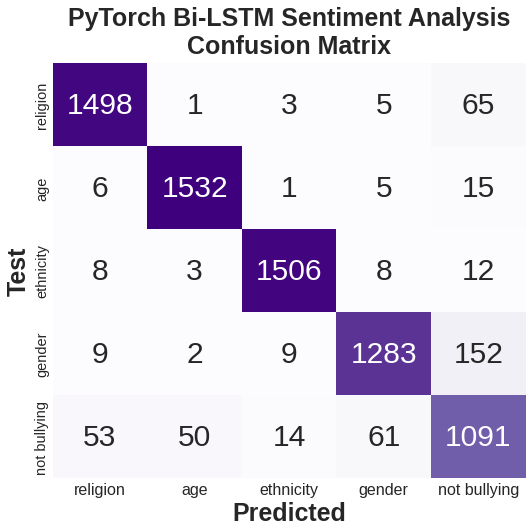

In [ ]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

\The performance scores has an overall accuracy of 93%. The F1 scores are over 90% for all the cyberbullying classes.

# BERT Classification

Load a pre trained BERT model from the Hugging Face library and fine tune it for the classification task.

### Train - Validation - Test split¶

In [ ]:
X = df['text_clean'].values
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [ ]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

#### BERT Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Create a custom tokenizer function for loading the tokenizer

In [ ]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens to understand input properly
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In order to specify the length of the longest tokenized sentence, tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the length of the longest sentence.

In [ ]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Get the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  126


In [ ]:
MAX_LEN = 126

In [ ]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#### Data preprocessing for BERT model

In [ ]:
#convert the arrays and target columns to  tensors 
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

In [ ]:
# create dataloaders for fine-tuning the BERT model, the original authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for the training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for the validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for the  test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#### BERT Modeling

Create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task

In [ ]:
%%time
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Add dense layers to perform the classification
        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        # Freezing the pretrained part of a BertForSequenceClassification model &  train the model as a classifier
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input data to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 32.9 µs


#### Define Learning rate and a learning rate scheduler:
Linear Warmup is a learning rate schedule where we linearly increase the learning rate from a low rate to a constant rate thereafter. This reduces volatility in the early stages of training.<br>

get_linear_schedule_with_warmup: It creates a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer. <br>

Optimizer: AdamW yields better training loss and that the models generalize much better than models trained with Adam 

In [ ]:
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)
    
    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )
    
    ### Set up learning rate scheduler ###

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

intialize the BERT model calling the "initialize_model" function

In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

#### BERT Training

Cross entropy Loss function for the multiclass classification task

In [ ]:
# Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # do not want to update the params during the evaluation,
            # since we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [ ]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.697109   |   65.03  
   200    |   0.318251   |   64.50  
   300    |   0.285453   |   64.49  
   400    |   0.255625   |   64.54  
   500    |   0.250683   |   64.56  
   600    |   0.245719   |   64.51  
   700    |   0.258898   |   64.55  
   800    |   0.229608   |   64.55  
   900    |   0.263789   |   64.51  
  1000    |   0.224245   |   64.54  
  1100    |   0.167603   |   64.53  
  1200    |   0.246534   |   64.51  
  1300    |   0.209628   |   64.53  
  1400    |   0.204364   |   64.48  
  1500    |   0.206236   |   64.55  
  1600    |   0.190714   |   64.51  
  1700    |   0.190836   |   64.50  
  1775    |   0.196575   |   48.35  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------

#### BERT Prediction

In [ ]:
# Define a function to return prediction list from test dataset
def bert_predict(model, test_dataloader):
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [ ]:
# call the defined function and get the class predictions of the test data
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [ ]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.96      0.95      0.95      1579
         age       0.98      0.99      0.98      1566
   ethnicity       0.99      0.99      0.99      1542
      gender       0.92      0.91      0.92      1462
not bullying       0.84      0.85      0.85      1274

    accuracy                           0.94      7423
   macro avg       0.94      0.94      0.94      7423
weighted avg       0.94      0.94      0.94      7423



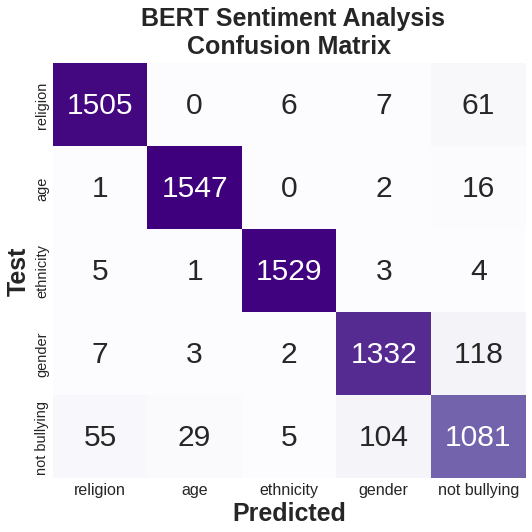

In [ ]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model with an overall accuracy of 94% and F1 scores over 95%.

# Cyberbullying Tweets Network Analysis & Graphs

Analyse the top frequency words and most used words phrases and visualize them using column charts.<br>

Parallel Coordinates Plot (PCP) is a visualization technique used to analyze multivariate numerical data and for comparing many quantitative variables together by looking for patterns and relationships between them.<br>

In [ ]:
# import libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for interactive visualization 
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.express as px # In config.py replace defaulys with: defaults = yaml.safe_load(f)
import plotly.graph_objects as go
init_notebook_mode(connected=True)

#cufflinks connects plotly with pandas to create graphs and charts of dataframes directly
import cufflinks as cf
cf.go_offline()

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df_network.sentiment.value_counts()

religion             7946
age                  7884
ethnicity            7744
not_cyberbullying    7637
gender               7607
Name: sentiment, dtype: int64

In [ ]:
df_network.head()

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...,8


In [ ]:
def cyberbullying_type_data(cb_type, column_name='sentiment'):
    subset = df_network[df_network[column_name] == cb_type]
    text_data = subset.text_clean.values
    return text_data

In [ ]:
def top_frequency_words(text, ng_range=(1,1), n=None):
    vector = CountVectorizer(ngram_range = ng_range, stop_words = stop_words).fit(text)
    bag_of_words = vector.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def most_used_words_phrases(cb_data, n=10):
    unigrams = top_frequency_words(cb_data,(1,1),n)
    unigram_data = pd.DataFrame(unigrams, columns = ['Text' , 'count'])
    return unigram_data

### Create datasets of specific criterion of cyberbullying as obtained from the original dataset

In [ ]:
gender_data = most_used_words_phrases(cyberbullying_type_data('gender'), 20)
religion_data = most_used_words_phrases(cyberbullying_type_data('religion'), 20)
ethnicity_data = most_used_words_phrases(cyberbullying_type_data('ethnicity'), 10)
age_data = most_used_words_phrases(cyberbullying_type_data('age'), 20)
not_cb_data = most_used_words_phrases(cyberbullying_type_data('not_cyberbullying'), 20)

In [ ]:
def create_word_bar(data, title):
    fig = px.bar(data, x = 'Text', y = 'count', color = 'Text',
                     labels={'count': "Word Frequency"},
                     title=title)
    fig.show(renderer="colab")

In [ ]:
# Plotting the bar graph for each criterion
create_word_bar(gender_data, 'Gender')
create_word_bar(religion_data, 'Religion')
create_word_bar(ethnicity_data, 'Ethnicity')
create_word_bar(age_data, 'Age')
create_word_bar(not_cb_data, 'Not Cyberbullying')


### Data Processing for Paralled Coordinate Graphs

In [ ]:
def create_cb_sets(cb_type):
    subset = df_network[df_network['sentiment'] == cb_type].text_clean.values
    unigrams = top_frequency_words(subset,(1,1), 100) # Just considering the top 100 in frequencies
    unigrams_data = pd.DataFrame(unigrams, columns = ['Text' , 'count'])
    return unigrams_data



In [ ]:
# Creating the criterion specific datasets
gender_cb_data = create_cb_sets('gender')
age_cb_data = create_cb_sets('age')
religion_cb_data = create_cb_sets('religion')
ethnicity_cb_data = create_cb_sets('ethnicity')
not_data = create_cb_sets('not_cyberbullying')
gender_cb_data.shape

(100, 2)

In [ ]:
# Performing an inner merge (intersection) of the gender and religion datasets.
intersecting_df = pd.merge(gender_cb_data, religion_cb_data, how='inner', on=['Text'])
modified_idf = intersecting_df.merge(age_cb_data, how='left', on=['Text']) #age

In [ ]:
# Renaming the default column names
modified_idf.rename(columns={'count_x': 'gender', 'count_y': 'religion', 'count': 'age'}, inplace=True)

In [ ]:
# Left joining the remaining datasets with keeping the Text column as common.
modified_idf = modified_idf.merge(ethnicity_cb_data, how='left', on=['Text']) #ethnicity
modified_idf.rename(columns={'count': 'ethnicity'}, inplace=True)
modified_idf = modified_idf.merge(not_data, how='left', on=['Text']) #not cb
modified_idf.rename(columns={'count': 'not cyberbullying'}, inplace=True)

In [ ]:
# Replacing the Nan values with zero
modified_idf['age'] = modified_idf['age'].fillna(0)
modified_idf['ethnicity'] = modified_idf['ethnicity'].fillna(0)
modified_idf['not cyberbullying'] = modified_idf['not cyberbullying'].fillna(0)
modified_idf.isna().sum()

Text                 0
gender               0
religion             0
age                  0
ethnicity            0
not cyberbullying    0
dtype: int64

In [ ]:
modified_idf.head()

,Text,gender,religion,age,ethnicity,not cyberbullying
0,call,1400,473,412.0,1381.0,103.0
1,make,1285,434,446.0,295.0,219.0
2,peopl,988,1075,934.0,1181.0,272.0
3,like,976,1275,2079.0,1035.0,424.0
4,women,895,309,0.0,0.0,152.0


In [ ]:
# Generating the Paralled Coordinates Plot
fig = px.parallel_coordinates(modified_idf, color='gender', labels={
                "gender": "gender",
                "religion": "religion",
                "age": "age",
                # "ethnicity": "ethnicity",
                "not cyberbullying": "not cyberbullying"},
                )
fig.show(renderer="colab") 

The above plot shows that a lot of cyberbullying posts might not be directed just towards one criterion, 
but can be thought or perceived as a negative post in multiple criteria.

## NETWORK ANALYSIS WITH GRAPHS

A network graph is a chart that displays relationships between elements (nodes) using simple links. Network graphs allows us to visualize clusters and relationships between the nodes quickly.

To create the network of words, generate word pairs as bigrams. Till now, unigrams were used for plots and analysis. Generate bigrams of those words which carry the main weight or sentiment of the whole text body. In simpler words, they are those word phrases which are giving the whole text an bullying sentiment. 

Bigrams might contain more meaning and weight as compared to unigrams and are used for network analysis. Also as obaserved in the Paralled Coordinate plot above that many unigrams are occuring for multiple types of cyberbullying category. For example the word women is taken into account for multiple cyberbullying type categories such as gender and religion. To make it quick and easy to observe this type of relation and how many words might be interconnected within or across multiple categories, so as to create network plots as below.

By using a DiGraph class from the network, it is the base class for directed graphs and can store nodes and edges with many optional data.

The degree of each node is the number of edges adjacent to the node. The nodes in the plots will be coloured according to the size of the node.




In [ ]:
# For studying graphs and networks
import networkx as nx
from networkx.drawing.layout import spring_layout

#creating interactive visualizations for web browsers
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap

In [ ]:
output_notebook()

In [ ]:
# initializing the graph
def make_networks(cyberbullying_type):
    subset = df_network[df_network['sentiment'] == cyberbullying_type].text_clean.values
    bigrams = top_frequency_words(subset,(2,2), 100)
    
    bigrams_list = []
    for bigram in bigrams:
        bigrams_list.append(bigram[0].split())
    graph = nx.DiGraph()
    #Adding the Nodes
    for node in bigrams_list:
        graph.add_nodes_from([node[0]])
    # Connecting the nodes with Edges
    for edge in bigrams_list:
        graph.add_edges_from([(edge[0], edge[1])])

    # Determing the degree of each node, that is the number of connected edges adjacent to a node.
    degrees = dict(nx.degree(graph))

    nx.set_node_attributes(graph, name = 'degree', values = degrees)
    # Adding an offset number of 5 so that nodes with small degree are also visible in the graph visualization
    number_to_adjust_by = 5
    adjusted_node_size = dict([(node, degree + number_to_adjust_by) for node, degree in nx.degree(graph)])
    nx.set_node_attributes(graph, name = 'adjusted_node_size', values = adjusted_node_size)

    size_by_this_attribute = 'adjusted_node_size'
    color_by_this_attribute = 'adjusted_node_size'

    #     Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
    color_palette = Blues8
    # if cyberbullying_type == "ethnicity":
    #     color_palette = Reds8
    if cyberbullying_type == "gender":
        color_palette = Blues8
    elif cyberbullying_type == "age":
        color_palette = Purples8
    elif cyberbullying_type == "religion":
        color_palette = Viridis8
    elif cyberbullying_type == "not_cyberbullying":
     color_palette = Spectral8

    title = cyberbullying_type
    HOVER_TOOLTIPS = [
        ("Character", "@index"),
        ("Degree", "@degree")
    ]
    plot = figure(tooltips = HOVER_TOOLTIPS,
                  tools = "pan, wheel_zoom, save, reset", active_scroll = 'wheel_zoom',
                x_range = Range1d(-10.1, 10.1), y_range = Range1d(-10.1, 10.1), title = title)
    network_graph = from_networkx(graph, nx.spring_layout, scale=10, center = (0, 0))

    minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
    maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
    network_graph.node_renderer.glyph = Circle(size = size_by_this_attribute, 
                                               fill_color = linear_cmap(color_by_this_attribute, 
                                                                        color_palette, 
                                                                        minimum_value_color,
                                                                        maximum_value_color)
                                              )

    network_graph.edge_renderer.glyph = MultiLine(line_alpha = 0.5, line_width = 1)
    plot.renderers.append(network_graph)
    return (plot, degrees, graph)


In [ ]:
# calling the make_networks to get the graph plot data and degree of each node in each category
gender_network_plot, gender_degree, gender_graph = make_networks('gender')
age_network_plot, age_degree, age_graph = make_networks('age')
religion_network_plot, religion_degree, religion_graph = make_networks('religion')
ethnicity_network_plot, ethnicity_degree, ethnicity_graph = make_networks('ethnicity')
not_cb_network_plot, not_cb_degree, not_cb_graph = make_networks('not_cyberbullying')

In [ ]:
# displaying the interactive network plots
show(gender_network_plot)
show(age_network_plot)
show(religion_network_plot)
show(ethnicity_network_plot)
show(not_cb_network_plot)

## Plotting the Degree of Each Node in Each Category

A bar plot represents degree of each node in each category. It will help to visualize which are the most common words carrying the maximum sentiment of the twitter post. Also have a look at the frequency of these words used with other to target specific groups of population or specific type of sentiment. 
The degree of each node in a particular category is stored in its respective dictionary.

In [ ]:
print('Degree of each Node in the Gender category:- ', gender_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Age category:- ', age_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Religion category:- ', religion_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Ethnicity category:- ', ethnicity_degree)
print("--------------------------------------------------------------------")
print('Degree of each Node in the Not Cyberbullying category:- ', not_cb_degree)
print("--------------------------------------------------------------------")

Degree of each Node in the Gender category:-  {'rape': 17, 'gay': 28, 'joke': 23, 'make': 9, 'rt': 3, 'call': 10, 'prison': 2, 'fuck': 2, 'use': 3, 'made': 3, 'femal': 7, 'miley': 1, 'gon': 1, 'date': 2, 'racist': 1, 'sexist': 7, 'sexual': 1, 'im': 2, 'bitch': 4, 'wan': 1, 'cyru': 2, 'peopl': 5, 'look': 1, 'arent': 2, 'say': 1, 'like': 6, 'colleagu': 2, 'funni': 6, 'child': 1, 'think': 3, 'act': 1, 'never': 2, 'dont': 2, 'year': 2, 'laugh': 1, 'amp': 4, 'mental': 1, 'hate': 1, 'got': 1, 'kill': 1, 'tran': 1, 'homophob': 1, 'man': 2, 'men': 1, 'insult': 1, 'na': 2, 'women': 2, 'dog': 1, 'victim': 1, 'assault': 1, 'word': 1, 'fun': 1, 'slur': 1, 'sex': 1, 'cultur': 1, 'guy': 1, 'marriag': 1, 'girl': 1, 'old': 1, 'etc': 1, 'ago': 1, 'ill': 1, 'ta': 1, 'us': 1, 'right': 1}
--------------------------------------------------------------------
Degree of each Node in the Age category:-  {'high': 13, 'bulli': 30, 'girl': 21, 'school': 29, 'middl': 3, 'got': 3, 'get': 4, 'look': 1, 'mean': 1, 'w

In [ ]:
# function to plot the degrees of each node
def plot_degree_of_nodes(degrees, title):
    fig = px.bar(x = list(degrees.keys()), y = list(degrees.values()), color = list(degrees.values()),
                         labels={
                             'y': "Degree",
                             'x': "Nodes"
                         },
                 title = title
                         )
    fig.update_layout(xaxis_tickangle=-45)
    fig.show(renderer="colab")

In [ ]:
# calling the functions to plot degree of nodes
plot_degree_of_nodes(gender_degree, 'Gender')
plot_degree_of_nodes(age_degree, 'Age')
plot_degree_of_nodes(religion_degree, 'Religion')
plot_degree_of_nodes(ethnicity_degree, 'Ethincity')
plot_degree_of_nodes(not_cb_degree, 'Not Cyberbullying')